## 12-1. 프로젝트 : 자율주행 보조 시스템 만들기
---
### 목차
    1. 자율주행 시스템 만들기
    2. 자율주행 시스템 평가하기

---
### 라이브러리

In [51]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

### 데이터셋
- 데이터셋 : [KITTI](http://www.cvlibs.net/datasets/kitti/)
    - 자율주행을 위한 데이터셋
    - 2D Object Dectection 뿐 아니라 깊이까지 포함한 3D Object Detection 라벨 등 제공

In [52]:
DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


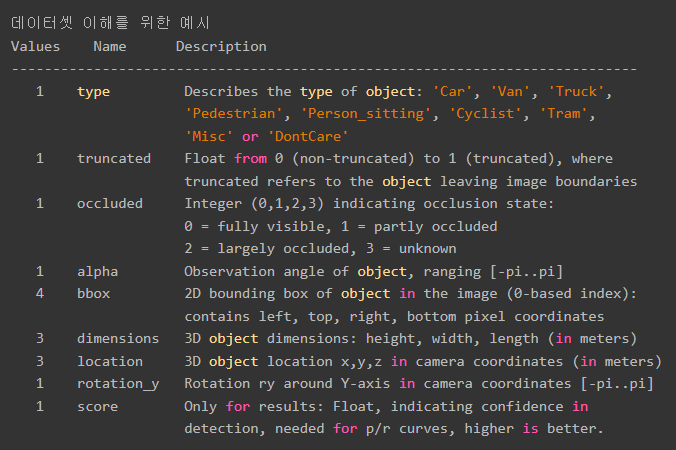

In [53]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/file_name': Text(shape=(), dtype=tf.string),
    'objects': Sequence({
        'alpha': tf.float32,
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'dimensions': Tensor(shape=(3,), dtype=tf.float32),
        'location': Tensor(shape=(3,), dtype=tf.float32),
        'occluded': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
        'rotation_y': tf.float32,
        'truncated': tf.float32,
        'type': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
})


### 데이터셋 확인

In [54]:
print(tf.data.experimental.cardinality(ds_train)) 
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(6347, shape=(), dtype=int64)
tf.Tensor(711, shape=(), dtype=int64)


In [55]:
num_classes = ds_info.features['objects']['type'].num_classes
classes_name = ds_info.features['objects']['type'].names

print(f"클래스 갯수 : {num_classes}")
print(f"클래스 이름 : {classes_name}")

클래스 갯수 : 8
클래스 이름 : ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc']


- 각 데이터셋 확인

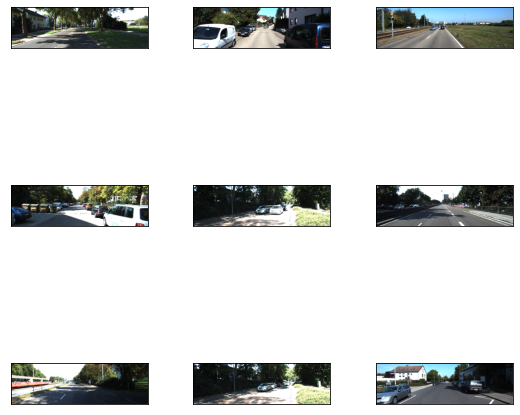

In [56]:
_ = tfds.show_examples(ds_train, ds_info)

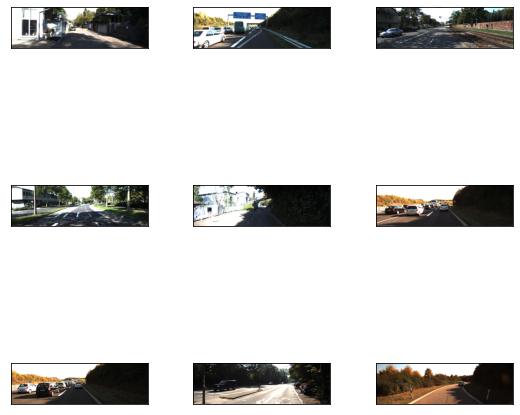

In [57]:
_ = tfds.show_examples(ds_test, ds_info)

In [58]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

- 학습용 데이터셋 확인하기

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ 1.77,  2.2 ,  2.1 ,  2.03,  1.68,  1.59, -1.56,  2.32, -2.09],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.36136   , 0.344533  , 0.5129333 , 0.40304348],
       [0.40712   , 0.04136071, 0.5268533 , 0.12635265],
       [0.43034667, 0.124219  , 0.51658666, 0.18652979],
       [0.43986666, 0.18375202, 0.5150667 , 0.23219807],
       [0.45546666, 0.42208534, 0.5226667 , 0.44914654],
       [0.48824   , 0.4490016 , 0.52786666, 0.46140096],
       [0.39986667, 0.46517712, 0.53016   , 0.50466186],
       [0.39685333, 0.        , 0.5152533 , 0.03697262],
       [0.35165334, 0.7712319 , 0.5011467 , 0.80359095]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.47, 1.43, 3.11],
       [1.71, 1.44, 4.06],
       [1.53, 1.67, 3.88],
       [1.53, 1.47, 4.05],
       [1.41,

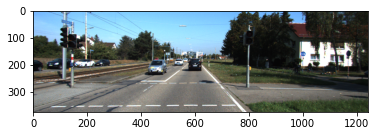

In [59]:
sample = ds_train.take(1)

for example in sample:
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

In [60]:
print(img.size)

(1242, 375)


- bounding box(bbox) 시각화

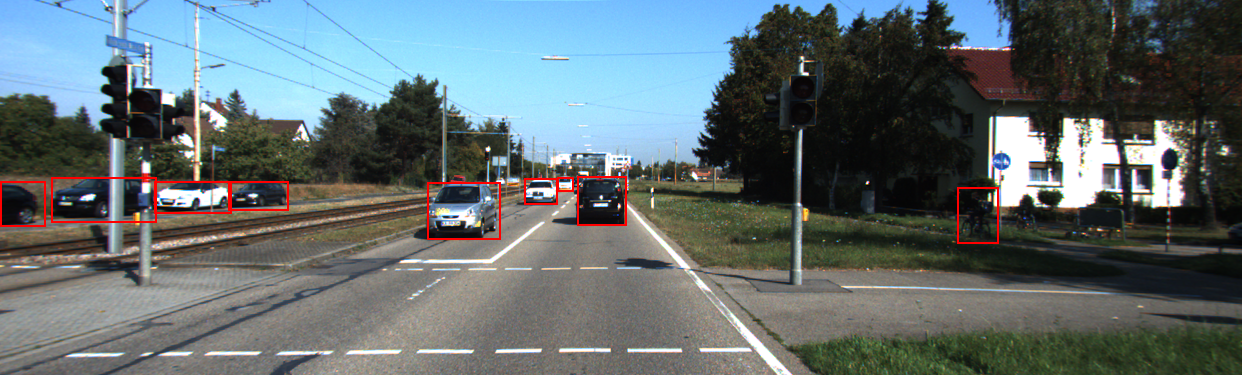

In [61]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### 데이터 준비 (전처리하기)
- 데이터를 학습에 맞는 형태로 바꾸어 주어야 한다.
- 이때 사용할 데이터 파이프라인을 구축한다.
- 데이터 파이프라인은 총 4단계로 구축한다.
    1. x와 y좌표 위치 교체
    2. 무작위로 수평 뒤집기(Flip)
    3. 이미지 크기 조정 및 패딩 추가
    4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

In [62]:
# 1. x와 y좌표 위치 교체
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('슝=3')

슝=3


In [63]:
# 무작위로 수평 뒤집기(Flip)
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )

    return image, boxes

print('슝=3')

슝=3


- 이미지 크기를 바꿀 때는 고려할 점이 있다.
    - 이미지의 비율은 그대로 유지되어야 하고,
    - 이미지의 최대/최소 크기도 제한해야 한다.
    - 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 만들어야 한다.
    - 이미지에 패딩을 추가하기 때문에 모델에 입력되는 이미지에는 검정 테두리가 있음

In [64]:
# 3. 이미지 크기 조정 및 패딩 추가
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0

    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

슝=3


In [65]:
# 4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

슝=3


- 준비된 함수들을 가공하는 함수

In [66]:
# 준비된 함수들을 가공하는 함수
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

슝=3


### 인코딩
- Anchor Box라는 정해져 있는 위치, 크기, 비율 중에 하나로 물체의 위치가 결정된다.
- 기본적으로 Anchor Box는 생성해줘야 한다.
    - Anchor Box = 물체 위치 후보
    - Anchor Box로부터 상하좌우로 떨어진 정도, 가로 세로의 크기 차이를 미세하게 찾아낸다.
    - Anchor Box가 촘촘하게 겹치도록 생성되기 때문에 물체를 잘 찾아낼 수 있다.

In [67]:
# Anchor Box 생성
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


- 입력할 데이터를 Anchor Box에 맞게 변형해줘야 한다.
- bbox = 주관식
- Anchor box = 객관식
- 모델은 객관식으로 문제를 풀어야 하기 때문에 주관식 정답을 가장 가까운 객관식 정답으로 바꿔줘야 모델을 학습할 수 있다.
<br/><br/>
- loU가 높은지 낮은지에 따라 Anchor Box가 정답인지 오답인지 체크해 두어 주관식 정답을 객관식 정답으로 바꿀 수 있다.

In [68]:
# 입력할 데이터를 Anchor Box에 맞게 변형해주는 함수
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

# loU가 낮은지 높은지 계산하는 함수
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

슝=3


- LabelEncoder 클래스
    - 실제 라벨을 Anchor Box에 맞춰주는 클래스
    - compute_iou에서 계산한 loU를 기준으로 
    - 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box 지정
    - Anchor Box와 실제 Bounding Box의 미세한 차이를 계산
    = 상하좌우의 차이, 가로세로 크기의 차이를 로그로 기록한다.

> variance
> - 관례적으로 Anchor Box를 사용할 때 등장
> - 상하좌우의 차이에는 0.1
> - 가로세로 크기의 차이에는 0.2를 사용한다.

In [69]:
# 실제 라벨을 Anchor Box에 맞춰주는 클래스
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

print('슝=3')

슝=3


### 모델 작성하기
- RetinaNet
    - FPN을 약간 수정해서 사용한다.
---
> RetinaNet
> - one-stage detector 모델이 속도느 빠르지만 성능이 낮은 문제 발생
> - 이를 해결하기 위해 focal loss와 FPN를 적용한 네트워크 사용
---
> Focal Loss
> - 물체를 배경보다 더 잘 학습하자 = 물체인 경우 Loss를 작게 만들자
> - 기존의 one-stage detection 모델이 물체 전경과 배경을 담고 있는 모든 그리드에 대해 한 번에 학습됨으로 인해 생기는 클래스 간의 불균형을 해결하고자 도입
> - 손실 함수에 모델이 잘못 예측한 샘플에 대한 가중치를 추가하는 방식으로 동작
> - 모델이 쉽게 분류할 수 있는 샘플에 대한 손실을 줄이기 위해 모듈레이팅 팩터(modulating factor = (1−pt​)γ)를 도입한다.
> - pt는 모델의 예측 확률이며, γ는 조절 파라미터이다.
> - 모델이 쉽게 분류할 수 있는 샘플(pt가 높은 경우)의 손실은 낮아지고, 모델이 어려운 샘플에 집중하도록 유도한다.
---
> FPN(Feature Pyramid Network)
> - 특성을 피라미드처럼 쌓아서 사용하는 방식

In [70]:
# FPN을 약간 수정한다.
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


- Object Dectection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분 = head
    - class를 예측하는 head
    - box를 예측하는 head

In [71]:
# 각각의 head를 만들어준다.
# class를 예측하는 head
# box를 예측하는 head
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


- ResNet50
    - RetinaNet의 Backbone
    - FPN에 이용할 수 있도록 중간 레이어도 output으로 연결

In [72]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


- RetinaNet
    - Backbone + FPN + Classification용 head + box용 head

In [73]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


- RetinaNetBoxLoss
    - Classification Loss를 계산 => Focal Loss
        - alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라진다.
    - Box Regression => Smooth L1 Loss
        - delta를 기준으로 계산이 달라진다.
       > Smooth L1 Loss
        > - 물체의 위치를 예측하는 회귀 문제에서 기존의 MSE Loss 대신에 쓰이는 것이 특징
        > - 물체의 위치를 정확히 예측하는 것이 목적
        > - 일반적으로 객체 검출 모델은 물체의 bounding box의 위치를 예측하는 데,
        > - 이 예측과 실제 bounding box의 차이를 측정하는 손실 함수

In [74]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


### 모델 학습
- 모델 학습 준비하기

In [75]:
batch_size = 2

# ResNet을 백본으로 사용하는 함수 호출
resnet50_backbone = get_backbone()

# RetinaNet 모델에서 사용될 손실 함수 초기화
loss_fn = RetinaNetLoss(num_classes)

# RetinaNet 모델 생성
model = RetinaNet(num_classes, resnet50_backbone)

- Learning Rate 설정하기

In [76]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer, metrics = ['accuracy'])

In [77]:
# 데이터를 전처리를 위한 파이프라인
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('슝=3')

슝=3


- 시간이 없어서 나눠서 학습했습니다.
- epochs 5 -> epochs 3

In [78]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/model_checkpoints/'

In [79]:
def model_fit(model, model_count, EPOCHS):
    callbacks_list = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(model_dir, f"{model_count}_weights" + "_epoch_{epoch}"),
            monitor="loss",
            save_best_only=False,
            save_weights_only=True,
            verbose=1,
        )
    ]

    epochs = EPOCHS

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks_list
    )
    
    accuracy_list = history.history['accuracy']
    val_accuracy_list = history.history['val_accuracy']
    loss_list = history.history['loss']
    val_loss_list = history.history['val_loss']

    history_lists = {
        'accuracy': accuracy_list,
        'val_accuracy': val_accuracy_list,
        'loss': loss_list,
        'val_loss': val_loss_list
    }

    return history_lists

In [81]:
model_fit(model, 1, 5)

Epoch 1/5
3173/3173 [==============================] - 1627s 512ms/step - loss: 2.4584 - accuracy: 0.2832 - val_loss: 1.7049 - val_accuracy: 0.2748

Epoch 00001: saving model to /aiffel/aiffel/object_detection/data/model_checkpoints/1_weights_epoch_1
Epoch 2/5
3173/3173 [==============================] - 1639s 513ms/step - loss: 1.0686 - accuracy: 0.2577 - val_loss: 1.3262 - val_accuracy: 0.2658

Epoch 00002: saving model to /aiffel/aiffel/object_detection/data/model_checkpoints/1_weights_epoch_2
Epoch 3/5
3173/3173 [==============================] - 1640s 513ms/step - loss: 0.7675 - accuracy: 0.2296 - val_loss: 1.1208 - val_accuracy: 0.2456

Epoch 00003: saving model to /aiffel/aiffel/object_detection/data/model_checkpoints/1_weights_epoch_3
Epoch 4/5
3173/3173 [==============================] - 1644s 515ms/step - loss: 0.6133 - accuracy: 0.2312 - val_loss: 1.0966 - val_accuracy: 0.2266

Epoch 00004: saving model to /aiffel/aiffel/object_detection/data/model_checkpoints/1_weights_epoc

{'accuracy': [0.28315335512161255,
  0.2576577067375183,
  0.22960713505744934,
  0.23116879165172577,
  0.2391388714313507],
 'val_accuracy': [0.27476537227630615,
  0.2658373713493347,
  0.24558456242084503,
  0.2265777438879013,
  0.24252142012119293],
 'loss': [2.458369493484497,
  1.0686379671096802,
  0.7675148248672485,
  0.6132516264915466,
  0.5022611618041992],
 'val_loss': [1.7048892974853516,
  1.3261847496032715,
  1.120813250541687,
  1.0965619087219238,
  1.0557057857513428]}

In [82]:
latest_checkpoint_dir = "/aiffel/aiffel/object_detection/data/model_checkpoints/"

def load_latest_checkpoint(model, checkpoint_dir):
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

    if latest_checkpoint is not None:
        model.load_weights(latest_checkpoint)
        print("모델 로드 성공")
    else:
        print("모델 체크포인트 없음")

In [84]:
load_latest_checkpoint(model, latest_checkpoint_dir)
model_fit(model, 2, 3)

모델 로드 성공
Epoch 1/3
3173/3173 [==============================] - 1644s 514ms/step - loss: 0.4276 - accuracy: 0.2264 - val_loss: 1.0671 - val_accuracy: 0.2149

Epoch 00001: saving model to /aiffel/aiffel/object_detection/data/model_checkpoints/2_weights_epoch_1
Epoch 2/3
3173/3173 [==============================] - 1652s 515ms/step - loss: 0.3694 - accuracy: 0.2183 - val_loss: 0.9838 - val_accuracy: 0.2007

Epoch 00002: saving model to /aiffel/aiffel/object_detection/data/model_checkpoints/2_weights_epoch_2
Epoch 3/3
3173/3173 [==============================] - 1652s 515ms/step - loss: 0.3228 - accuracy: 0.2097 - val_loss: 1.0330 - val_accuracy: 0.2259

Epoch 00003: saving model to /aiffel/aiffel/object_detection/data/model_checkpoints/2_weights_epoch_3


{'accuracy': [0.2263953685760498, 0.21829116344451904, 0.20969106256961823],
 'val_accuracy': [0.2148793488740921,
  0.20065152645111084,
  0.22588326036930084],
 'loss': [0.42758476734161377, 0.369438111782074, 0.32281938195228577],
 'val_loss': [1.0670827627182007, 0.9838264584541321, 1.0330253839492798]}

In [85]:
import matplotlib.pyplot as plt

def plot_history(history_lists):
    # 훈련 및 검증 정확도
    plt.plot(history_lists['accuracy'], label='Train Accuracy')
    plt.plot(history_lists['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # 훈련 및 검증 손실
    plt.plot(history_lists['loss'], label='Train Loss')
    plt.plot(history_lists['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [86]:
# 위에서 주어진 history_lists를 사용하여 시각화
# history_lists를 파일로 저장했어야 했는데, 못해서 저장된 리스트 하드코딩...
history_lists = {'accuracy': [0.28315335512161255,
  0.2576577067375183,
  0.22960713505744934,
  0.23116879165172577,
  0.2391388714313507, 0.2263953685760498, 0.21829116344451904, 0.20969106256961823],

 'val_accuracy': [0.27476537227630615,
  0.2658373713493347,
  0.24558456242084503,
  0.2265777438879013,
  0.24252142012119293, 0.2148793488740921,
  0.20065152645111084,
  0.22588326036930084],

 'loss': [2.458369493484497,
  1.0686379671096802,
  0.7675148248672485,
  0.6132516264915466,
  0.5022611618041992, 0.42758476734161377, 0.369438111782074, 0.32281938195228577],

 'val_loss': [1.7048892974853516,
  1.3261847496032715,
  1.120813250541687,
  1.0965619087219238,
  1.0557057857513428, 1.0670827627182007, 0.9838264584541321, 1.0330253839492798]
}

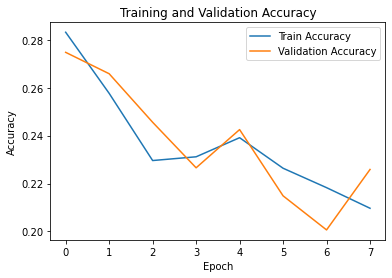

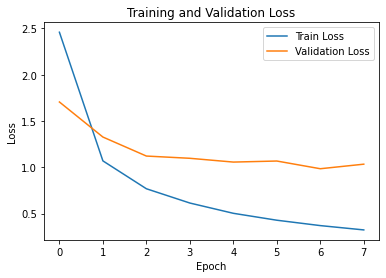

In [87]:
plot_history(history_lists)

### 결과 확인하기
- 학습된 모델 불러오기
- 모델의 추론 결과를 처리할 함수를 레이어 형식으로 생성하기
    - 100개의 후보만 골라 처리
    - NMS(Non-Max Suppression)

In [88]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

슝=3


- 추론이 가능한 모델을 조립한다.

In [89]:
# 추론이 가능한 모델을 조립한다.
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

슝=3


- 모델의 추론 결과를 시각화 할 함수를 만들어 준다.

In [116]:
# 모델의 추론 결과를 시각화 할 함수를 만들어 준다.
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


- 추론시에 입력 데이터를 전처리하기 위한 함수를 만든다.
- 학습을 위한 전처리와 추론을 위한 전처리가 다르다.

In [91]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


- 학습된 결과를 확인!

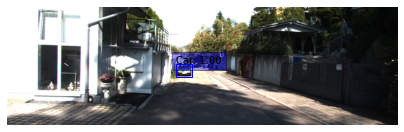

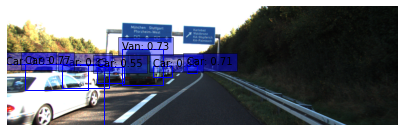

In [92]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

## 1. 자율주행 시스템 만들기
- 입력으로 이미지 경로를 받는다.
- 정지 조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환한다.
- 조건은 다음과 같다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우

In [113]:
car_list = ['Car', 'Van', 'Truck', 'Tram']
people_list = ['Pedestrian', 'Person_sitting', 'Cyclist']

In [127]:
def self_drive_assist(image_path, size_limit=300, to_visualize=True):
    int2str = ds_info.features["objects"]["type"].int2str

    image = Image.open(image_path).convert('RGB')
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.cast(image, dtype=tf.float32)
    
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]

    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]
    scores = detections.nmsed_scores[0][:num_detections]

    # Visualization
    if to_visualize:
        visualize_detections(image, boxes, class_names, scores)

    # Stop condition 1: If there is at least one person, return "Stop"
    if len(set(class_names) & set(people_list)) > 0:
        return "Stop"

    # Stop condition 2: If the size of the vehicle (W, H) is greater than or equal to size_limit, return "Stop"
    for box, class_name, score in zip(boxes, class_names, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        # print(f"w {w:.2f}, h {h:.2f}, w*h {w*h:.2f}")  # Print vehicle size
        if w >= size_limit or h >= size_limit:
            return "Stop"

    # Otherwise, return "Go"
    return "Go"

go_4.png


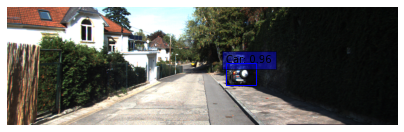

Go

stop_2.png


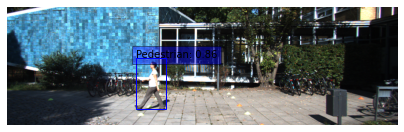

Stop

stop_1.png


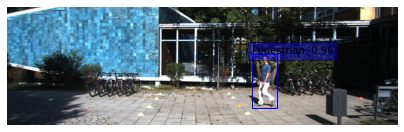

Stop

go_2.png


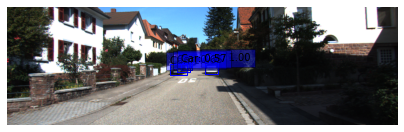

Go

go_5.png


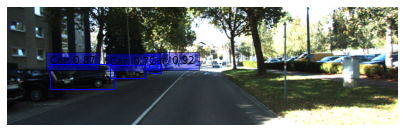

Go

stop_3.png


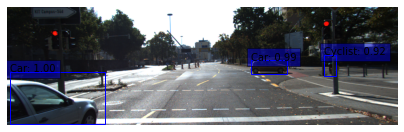

Stop

stop_5.png


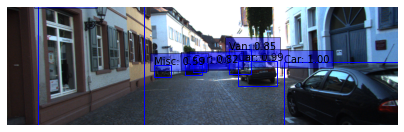

Stop

go_3.png


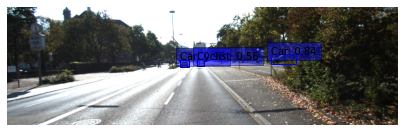

Stop

go_1.png


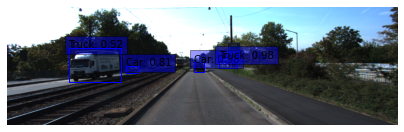

Go

stop_4.png


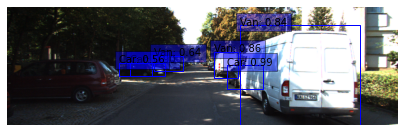

Stop



In [128]:
image_path_list = [image_path for image_path in os.listdir(DATA_PATH) if image_path.endswith('.png')]

for i, image_path in enumerate(image_path_list):
    print(image_path)
    print(self_drive_assist(os.path.join(DATA_PATH, image_path), size_limit=300, to_visualize=True))
    print('')

## 2. 자율주행 시스템 평가하기
- 아래 test_system()를 통해서 위에서 만든 함수를 평가해봅시다.

In [122]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
        print(f'{image_file} : 예측: {pred}, 정답: {answer}, 점수: {score}')
    print(f"{score}점입니다.")

test_system(self_drive_assist)

stop_1.png : 예측: Stop, 정답: Stop, 점수: 10
stop_2.png : 예측: Stop, 정답: Stop, 점수: 20
stop_3.png : 예측: Stop, 정답: Stop, 점수: 30
stop_4.png : 예측: Stop, 정답: Stop, 점수: 40
stop_5.png : 예측: Stop, 정답: Stop, 점수: 50
go_1.png : 예측: Go, 정답: Go, 점수: 60
go_2.png : 예측: Go, 정답: Go, 점수: 70
go_3.png : 예측: Stop, 정답: Go, 점수: 70
go_4.png : 예측: Go, 정답: Go, 점수: 80
go_5.png : 예측: Go, 정답: Go, 점수: 90
90점입니다.


## 회고
- 학습이 너무 오래걸려서 한번 윈도우 업데이트가 자동으로 실행돼서 재부팅돼어 학습된 기록이 날라가서 시간이 부족하여 에폭을 낮춰서 진행했다.
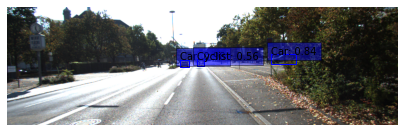
- go_3.png는 멀리 사람들과 자전거타는 사람이 있어 go 해야하지만 사람이 1명 이상있으면 stop해서 stop한 결과가 나온 것 같다.